In [131]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

iris = load_iris()

In [132]:
X = iris['data']
y = iris['target']

# randomly select 100 samples (2/3) for training, and 50 samples (1/3) for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1
)

In [133]:
# standardize the features (mean centering and dividing by standard deviation)
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

# create dataset for training
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

In [134]:
class Model(nn.Module):
    '''
        Each layer in neural network receives input from preceding layer.\n
        The model defined in the class consists of two hidden layers.\n
        The first input receives 4 hidden features and projects them to 16 neurons.\n
        The second layer receives the output from previous layer (of size 16),\n
        and projects them to the output of three neurons, since there are 3 class labels.
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size, dtype=torch.double)
        self.layer2 = nn.Linear(hidden_size, output_size, dtype=torch.double)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [135]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(
    input_size=input_size, 
    hidden_size=hidden_size, 
    output_size=output_size)

In [136]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [137]:
# train the model
num_epochs = 400
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).double()
        accuracy_hist[epoch] += is_correct.mean() * y_batch.size(0)
    len_dataset = len(train_dl.dataset)
    loss_hist[epoch] /= len_dataset
    accuracy_hist[epoch] /= len_dataset

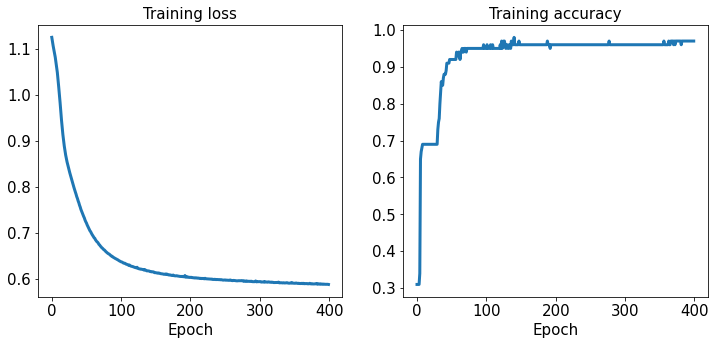

In [138]:
# visualize learning curves
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title("Training loss", size=15)
ax.set_xlabel("Epoch", size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title("Training accuracy", size=15)
ax.set_xlabel("Epoch", size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [139]:
# evaluate classification accuracy
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).double()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).double()
accuracy = correct.mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9800


In [21]:
# save training model
path = "./iris_classifier.pt"
torch.save(model, path)

In [22]:
# reload training model
model_new = torch.load(path)

# verify model architecture
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [23]:
# evaluate the loaded model and verify that results are the same as before
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).double()
accuracy = correct.mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9800


In [24]:
# saving only learned parameters
path = "./iris_classifier_state.pt"
torch.save(model.state_dict(), path)

In [25]:
# reload saved state of learned parameters
model_new = Model(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>